### Setting up data

In [3]:
class_data = ["circle.npy", "square.npy", "star.npy", "triangle.npy"]

class_names = ["circle", "square", "star", "triangle"]


#### Numpy Loading Function


In [4]:
import numpy as np


def load(dir, reshaped, files):
    data = []
    for file in files:
        f = np.load(dir + file)
        if reshaped:
            new_f = []
            for i in range(len(f)):
                x = np.reshape(f[i], (28, 28))
                x = np.expand_dims(x, axis = 0)
                x = np.reshape(f[i], (28, 28, 1))
                new_f.append(x)
            f = new_f
        data.append(f)
    return data

def set_limit(arrays, n):
    new = []
    for array in arrays:
        i = 0
        for item in array:
            if i == n:
                break
            new.append(item)
            i += 1
    return new

def make_labels(N1, N2):
    labels = []
    for i in range(N1):
        labels += [i] * N2
    return labels

(784,)


(28, 28)

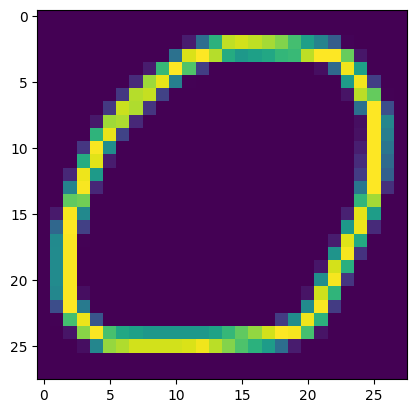

In [5]:
import matplotlib
import matplotlib.pyplot as plt

shapes = load("data/", False, ["circle.npy"])

img = shapes[0][1]

print(img.shape)

img = np.reshape(img, (28, 28))

plt.imshow(img)

img.shape


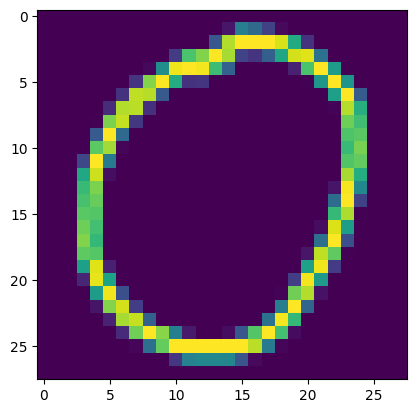

In [6]:
N = 5000

EPOCHS = 10


shapes = load("data/", True, class_data)

shapes = set_limit(shapes, N)

plt.imshow(shapes[0])



In [7]:
import os

target_dir = "data"

def get_classes(dir):
    class_names = sorted([os.path.splitext(entry.name)[0] for entry in os.scandir(dir)])
    return class_names


classes = get_classes(target_dir)

classes



['circle', 'square', 'star', 'triangle']

In [8]:
from typing import List, Optional
import urllib.request
from pathlib import Path
import torch
import math
import numpy as np
import os
import glob

In [9]:
def load_data(root = "./data", max_samples = 5000):
    files = Path(root).glob('*.npy')

    x = np.empty([0, 784], dtype = np.uint8)
    y = np.empty([0], dtype = np.longlong)
    class_names = []

    for idx, file in enumerate(sorted(files)):
        data = np.load(file, mmap_mode= 'r')
        data = data[0: max_samples, :]
        labels = np.full(data.shape[0], idx)
        x = np.concatenate((x, data), axis = 0)
        y = np.append(y, labels)

        class_names.append(file.stem)

    return x, y, class_names

class_names

class QuickDrawDataset(torch.utils.data.Dataset):
    def __init__(self,root, max_samples = 5000):
        super().__init__()
        self.root = root
        self.max_samples = max_samples

        self.X, self.Y, self.classes = load_data(self.root, self.max_samples)
    
    def __getitem__(self, idx):
        x = (self.X[idx] /255.).astype(np.float32).reshape(1, 28, 28)
        y = self.Y[idx]

        return torch.from_numpy(x), y.item()
    
    def __len__(self):
        return len(self.X)
    
    def collate_fn(self, batch):
        x = torch.stack([item[0] for item in batch])
        y = torch.LongTensor([item[1] for item in batch])
        return {'pixel_values' : x, 'labels': y}
    
    def split(self, pct = 0.1):
        num_classes = len(self.classes)
        indices = torch.randperm(len(self)).tolist()
        n_val = math.floor(len(indices) * pct)
        train_ds = torch.utils.data.Subset(self, indices[:-n_val])
        val_ds = torch.utils.data.Subset(self, indices[-n_val:])
        return train_ds, val_ds


#### Model

In [10]:
data_dir = './data'
max_samples = 20000
train_val_split_pct = 0.1

ds = QuickDrawDataset(data_dir, max_samples)
num_classes = len(ds.classes)
train_ds, val_ds = ds.split(train_val_split_pct)

In [11]:
from torch import nn
model = nn.Sequential(
    nn.Conv2d(1, 64, 3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(64, 128, 3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(128, 256, 3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(2304, 512),
    nn.ReLU(),
    nn.Linear(512, num_classes),
)



In [12]:
from torch.utils.data import DataLoader

num_batches = 256

train_batches = DataLoader(train_ds,
                           batch_size=num_batches,
                           shuffle=True)
test_batches = DataLoader(val_ds, 
                          batch_size = num_batches,
                          shuffle= True)

train_batch_features = next(iter(train_batches))
x , y = train_batch_features

x.shape



torch.Size([256, 1, 28, 28])

In [13]:
import torch
from torchvision import models

model = models.resnet18(pretrained=False)
model.conv1 = nn.Conv2d(1, model.conv1.out_channels, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

c:\Users\Nick-Uni\Desktop\Shapes_Project\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Nick-Uni\Desktop\Shapes_Project\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


#### Training


In [14]:
def train_step(model : torch.nn.Module,
                data_loader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                optimizer: torch.optim.Optimizer,
                accuracy_fn,
                device: torch.device):
    
    
    train_loss, train_acc = 0 , 0
    model.to(device)
    model.train()
    for batch, (X, y) in enumerate(data_loader):

        X, y = X.to(device, non_blocking = True), y.to(device, non_blocking = True)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)

        

        train_loss += loss.item()
        train_acc += accuracy_fn(y_true = y,
                                 y_pred = y_pred.argmax(dim = 1))
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()


    train_loss /= len(data_loader)
    train_acc /= len(data_loader)


    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

    return train_loss , train_acc
    


def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device : torch.device):
    
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:

            X, y = X.to(device, non_blocking = True), y.to(device, non_blocking = True)

            test_pred = model(X)

            test_loss += loss_fn(test_pred, y).item()
            test_acc += accuracy_fn(y_true = y, y_pred = test_pred.argmax(dim = 1))

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)

        print(f"Test Loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

        return test_loss, test_acc

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(),
                            lr = 0.0001)

In [16]:
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [17]:
from timeit import default_timer as timer 
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

device = "cuda"

In [18]:
from tqdm.auto import tqdm
from timeit import default_timer as timer

train_time_start_model_2 = timer()
atrain_loss_list = []
atrain_acc_list = []

atest_loss_list = []
atest_acc_list = []

epochs = 25


for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n")
    loss_train ,acc_train = train_step(data_loader = train_batches,
                    model = model,
                    loss_fn = loss_fn,
                    optimizer = optimizer,
                    accuracy_fn = accuracy_fn,
                    device = device)
    
    atrain_loss_list.append(loss_train)
    atrain_acc_list.append(acc_train)
                   
    loss_test, acc_test = test_step(data_loader = test_batches,
              model = model,
              loss_fn = loss_fn,
              accuracy_fn = accuracy_fn,
              device = device)
    
    atest_loss_list.append(loss_test)
    atest_acc_list.append(acc_test)

train_time_end_model = timer()
total_train_time_model = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model,
                                           device=device)

  0%|          | 0/25 [00:00<?, ?it/s]


Epoch: 0



AssertionError: Torch not compiled with CUDA enabled

In [139]:
print(device)


correct_pred = {classname: 0 for classname in class_names}
total_pred = {classname: 0 for classname in class_names}

# again no gradients needed
with torch.no_grad():
    for data in test_batches:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[class_names[label]] += 1
            total_pred[class_names[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

    

cuda
Accuracy for class: circle is 97.4 %
Accuracy for class: square is 96.4 %
Accuracy for class: star  is 97.4 %
Accuracy for class: triangle is 96.9 %


torch.Size([1, 1, 28, 28])
star


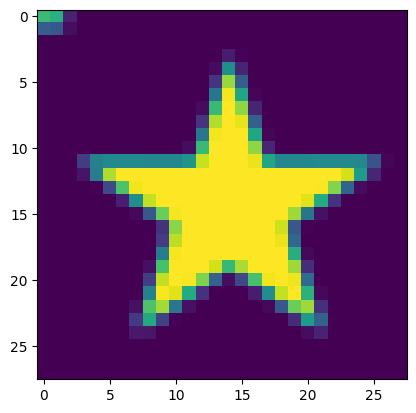

In [184]:
from torchvision import transforms
from PIL import Image



path = "star.png"
tf = transforms.Compose([transforms.ToTensor(),
                         transforms.Resize((28,28))
                
                         
])

img = Image.open(path).convert('L')


img_tf = tf(img).float().unsqueeze(0)
inverted_img = 1.0 - img_tf  # Subtract each pixel value from 1


plt.imshow(img_tf.squeeze())
# thresholded_img = (inverted_img > 0.5).float() # Any value > 0.5 becomes 1, else 0

plt.imshow(inverted_img.squeeze())
# plt.imshow(thresholded_img.squeeze())
# thresholded_img = (inverted_img > 0.5).float().to(device)  # Any value > 0.5 becomes 1, else 0

inverted_img = inverted_img.to(device)

img_tf = img_tf.to(device)


print(img_tf.shape)
model.eval()
with torch.no_grad():
    out = model.forward(inverted_img)
    _, y_pred = torch.max(out.data, 1)
    print(class_names[y_pred])